# IDS with Incremental Learning
In this notebook, we will use `creme`, a python library for online learning, and train a logistic regression sample by sample. Unlike our previous notebook, we do not shuffle the dataset before constructing our datastream. We find it makes little difference.

In [1]:
import string
import os
import pickle


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint

from creme import stream
from creme import model_selection
from creme import compose
from creme import feature_extraction
from creme import linear_model
from creme import metrics
from creme import preprocessing
from creme import stats


from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score

Reading in our data:

In [2]:
train_attack_types = pd.read_csv("datasets/training_attack_types.txt", delimiter=" ", header=None, names= ["attack_type", "attack_category"])

`cols` is a list of all of our column names (including 20+ columns that are the result of expertise-driven feature engineering); `reduced_cols` is the first nine column names plus the label. `reduced_cols` corresponds to basic packet metadata.

In [3]:
cols = list(pd.read_csv("datasets/kddcup.names.txt", skiprows=1, header=None)[0].map(lambda x: str(x).split(":")[0]).values)
cols.append("label")


reduced_cols = cols[:9]
reduced_cols.append("label")

reduced_cols

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'label']

# Train/test split
In online learning, we do not partition our data into a training set and a test set. Since we learn on a per-observation basis, EVERY observation is a test observation, and after we've made our prediction we can then use it as a training observation. It's quite elegant, actually! KDD itself _is_ partitioned into a training and test set, and most importantly, the test set contains attacks that are not present in the train set. Thus, performance on the test set is useful to measure how generalizable our classifier is.

In [4]:
train = pd.read_csv("datasets/kddcup.data.corrected.txt", header=None, names=cols)

Discard the columns that are engineered features:

In [5]:
train = train[reduced_cols].copy()

In [6]:
test = pd.read_csv("datasets/corrected.txt", header=None, names=cols)

Discard the columns that are engineered features:

In [7]:
test = test[reduced_cols].copy()

In [8]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,label
0,0,tcp,http,SF,215,45076,0,0,0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,normal.
4,0,tcp,http,SF,239,486,0,0,0,normal.


In [9]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,label
0,0,udp,private,SF,105,146,0,0,0,normal.
1,0,udp,private,SF,105,146,0,0,0,normal.
2,0,udp,private,SF,105,146,0,0,0,normal.
3,0,udp,private,SF,105,146,0,0,0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,snmpgetattack.


# Preprocessing

## Process the label column
We want to generate a binary label:

In [10]:
train["label"] = train["label"].map(lambda x: x.split(".")[0])
test["label"] = test["label"].map(lambda x: x.split(".")[0])

### Binary label (normal/malicious)

In [11]:
train["label_binary"] = train["label"].map(lambda x: 0 if x=="normal" else 1)
test["label_binary"] = test["label"].map(lambda x: 0 if x=="normal" else 1)

In [12]:
test["label_binary"].value_counts()

1    250436
0     60593
Name: label_binary, dtype: int64

In [13]:
train["label_binary"].value_counts()

1    3925650
0     972781
Name: label_binary, dtype: int64

In [14]:
# X = pd.get_dummies(train, columns=["protocol_type", "service", "flag"], drop_first=True).drop(columns=["label", "label_binary"])
# train_shuffled = train.sample(frac=1).reset_index(drop=True)

# Incremental Logistic Regression
## Data stream
Here we will build our data stream

In [15]:
train.shape

(4898431, 11)

There is no need for a holdout set in an online setting. This code is like this for legacy reasons.

In [16]:
N = 4898431

In [17]:
holdout = train.iloc[N:].copy().reset_index(drop=True)
train = train.iloc[:N].reset_index(drop=True)

In [18]:
datastream = stream.iter_pandas(train.drop(columns=["label_binary", "label"]), train["label_binary"])
teststream = stream.iter_pandas(holdout.drop(columns=["label_binary", "label"]), holdout["label_binary"])

## Pipeline
We will scale and one-hot-encode.

In [19]:
train.dtypes

duration           int64
protocol_type     object
service           object
flag              object
src_bytes          int64
dst_bytes          int64
land               int64
wrong_fragment     int64
urgent             int64
label             object
label_binary       int64
dtype: object

In [20]:
cols_string = [col for col,col_type in zip(train.columns[:-2], train.dtypes[:-2]) if col_type == "object"]

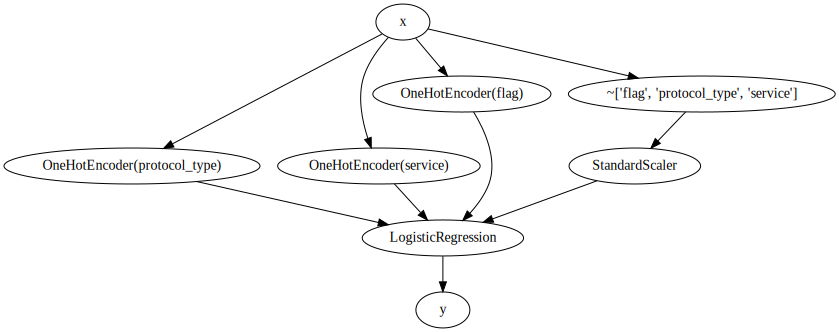

In [21]:
ohe_list = [preprocessing.OneHotEncoder(col) for col in cols_string]
string_processor = (compose.TransformerUnion(ohe_list))

num_processor = compose.Blacklister(*cols_string)|preprocessing.StandardScaler()

model = string_processor + num_processor
model |= linear_model.LogisticRegression()
model.draw()

In [22]:
# rocauc = metrics.ROCAUC()
cm = metrics.ConfusionMatrix()
recall = metrics.Recall()
f1 = metrics.F1()
precision = metrics.Precision()

counter=0

y_actual = []
y_preds = []
for x,y in datastream:
    if counter%10000 == 0:
        print(f"Current iteration: {counter}")
#         print(f"Current confusion matrix: {cm}")
        print(f"Current recall: {recall}")
        print(f"Current f1: {f1}")
        print(f"Current precision: {precision}")
        print()
    y_pred= model.predict_one(x)
    
    y_actual.append(y)
    y_preds.append(y_pred)
#     rocauc.update(y, y_pred)
    cm.update(y, y_pred)
    recall.update(y, y_pred)
    f1.update(y, y_pred)
    precision.update(y, y_pred)
    
    model.fit_one(x, y)
    counter+=1
# print(rocauc)
# print(cm)
print(recall)
print(f1)
print(precision)

Current iteration: 0
Current recall: Recall: 0.
Current f1: F1: 0.
Current precision: Precision: 0.

Current iteration: 10000
Current recall: Recall: 0.
Current f1: F1: 0.
Current precision: Precision: 0.

Current iteration: 20000
Current recall: Recall: 0.
Current f1: F1: 0.
Current precision: Precision: 0.

Current iteration: 30000
Current recall: Recall: 0.
Current f1: F1: 0.
Current precision: Precision: 0.

Current iteration: 40000
Current recall: Recall: 0.
Current f1: F1: 0.
Current precision: Precision: 0.

Current iteration: 50000
Current recall: Recall: 0.
Current f1: F1: 0.
Current precision: Precision: 0.

Current iteration: 60000
Current recall: Recall: 0.
Current f1: F1: 0.
Current precision: Precision: 0.

Current iteration: 70000
Current recall: Recall: 0.
Current f1: F1: 0.
Current precision: Precision: 0.

Current iteration: 80000
Current recall: Recall: 0.937027
Current f1: F1: 0.96749
Current precision: Precision: 1.

Current iteration: 90000
Current recall: Recall:

Current iteration: 680000
Current recall: Recall: 0.995871
Current f1: F1: 0.996998
Current precision: Precision: 0.998128

Current iteration: 690000
Current recall: Recall: 0.99601
Current f1: F1: 0.997099
Current precision: Precision: 0.998191

Current iteration: 700000
Current recall: Recall: 0.99614
Current f1: F1: 0.997194
Current precision: Precision: 0.99825

Current iteration: 710000
Current recall: Recall: 0.996262
Current f1: F1: 0.997283
Current precision: Precision: 0.998306

Current iteration: 720000
Current recall: Recall: 0.996376
Current f1: F1: 0.997366
Current precision: Precision: 0.998358

Current iteration: 730000
Current recall: Recall: 0.99638
Current f1: F1: 0.997253
Current precision: Precision: 0.998127

Current iteration: 740000
Current recall: Recall: 0.996034
Current f1: F1: 0.997078
Current precision: Precision: 0.998123

Current iteration: 750000
Current recall: Recall: 0.996008
Current f1: F1: 0.996917
Current precision: Precision: 0.997828

Current iter

Current iteration: 1340000
Current recall: Recall: 0.997756
Current f1: F1: 0.998144
Current precision: Precision: 0.998533

Current iteration: 1350000
Current recall: Recall: 0.997637
Current f1: F1: 0.997966
Current precision: Precision: 0.998294

Current iteration: 1360000
Current recall: Recall: 0.997637
Current f1: F1: 0.997966
Current precision: Precision: 0.998294

Current iteration: 1370000
Current recall: Recall: 0.997637
Current f1: F1: 0.997966
Current precision: Precision: 0.998294

Current iteration: 1380000
Current recall: Recall: 0.997579
Current f1: F1: 0.997936
Current precision: Precision: 0.998294

Current iteration: 1390000
Current recall: Recall: 0.997336
Current f1: F1: 0.997788
Current precision: Precision: 0.998241

Current iteration: 1400000
Current recall: Recall: 0.996957
Current f1: F1: 0.997588
Current precision: Precision: 0.99822

Current iteration: 1410000
Current recall: Recall: 0.996801
Current f1: F1: 0.997437
Current precision: Precision: 0.998074

C

Current iteration: 2000000
Current recall: Recall: 0.997565
Current f1: F1: 0.998184
Current precision: Precision: 0.998803

Current iteration: 2010000
Current recall: Recall: 0.997583
Current f1: F1: 0.998198
Current precision: Precision: 0.998813

Current iteration: 2020000
Current recall: Recall: 0.997602
Current f1: F1: 0.998211
Current precision: Precision: 0.998822

Current iteration: 2030000
Current recall: Recall: 0.99762
Current f1: F1: 0.998225
Current precision: Precision: 0.998831

Current iteration: 2040000
Current recall: Recall: 0.997638
Current f1: F1: 0.998238
Current precision: Precision: 0.998839

Current iteration: 2050000
Current recall: Recall: 0.997656
Current f1: F1: 0.998252
Current precision: Precision: 0.998848

Current iteration: 2060000
Current recall: Recall: 0.997673
Current f1: F1: 0.998265
Current precision: Precision: 0.998857

Current iteration: 2070000
Current recall: Recall: 0.99769
Current f1: F1: 0.998277
Current precision: Precision: 0.998865

Cu

Current iteration: 2660000
Current recall: Recall: 0.99839
Current f1: F1: 0.998799
Current precision: Precision: 0.999209

Current iteration: 2670000
Current recall: Recall: 0.998398
Current f1: F1: 0.998806
Current precision: Precision: 0.999213

Current iteration: 2680000
Current recall: Recall: 0.998406
Current f1: F1: 0.998812
Current precision: Precision: 0.999217

Current iteration: 2690000
Current recall: Recall: 0.998414
Current f1: F1: 0.998818
Current precision: Precision: 0.999221

Current iteration: 2700000
Current recall: Recall: 0.998422
Current f1: F1: 0.998824
Current precision: Precision: 0.999225

Current iteration: 2710000
Current recall: Recall: 0.99843
Current f1: F1: 0.998829
Current precision: Precision: 0.999229

Current iteration: 2720000
Current recall: Recall: 0.998438
Current f1: F1: 0.998835
Current precision: Precision: 0.999233

Current iteration: 2730000
Current recall: Recall: 0.998446
Current f1: F1: 0.998841
Current precision: Precision: 0.999237

Cu

Current iteration: 3320000
Current recall: Recall: 0.998797
Current f1: F1: 0.999103
Current precision: Precision: 0.999409

Current iteration: 3330000
Current recall: Recall: 0.998802
Current f1: F1: 0.999107
Current precision: Precision: 0.999412

Current iteration: 3340000
Current recall: Recall: 0.998807
Current f1: F1: 0.99911
Current precision: Precision: 0.999414

Current iteration: 3350000
Current recall: Recall: 0.998811
Current f1: F1: 0.999114
Current precision: Precision: 0.999416

Current iteration: 3360000
Current recall: Recall: 0.998816
Current f1: F1: 0.999117
Current precision: Precision: 0.999418

Current iteration: 3370000
Current recall: Recall: 0.99882
Current f1: F1: 0.99912
Current precision: Precision: 0.999421

Current iteration: 3380000
Current recall: Recall: 0.998824
Current f1: F1: 0.999124
Current precision: Precision: 0.999423

Current iteration: 3390000
Current recall: Recall: 0.998829
Current f1: F1: 0.999127
Current precision: Precision: 0.999425

Cur

Current iteration: 3980000
Current recall: Recall: 0.998845
Current f1: F1: 0.999059
Current precision: Precision: 0.999273

Current iteration: 3990000
Current recall: Recall: 0.998848
Current f1: F1: 0.999062
Current precision: Precision: 0.999275

Current iteration: 4000000
Current recall: Recall: 0.998852
Current f1: F1: 0.999065
Current precision: Precision: 0.999277

Current iteration: 4010000
Current recall: Recall: 0.998855
Current f1: F1: 0.999067
Current precision: Precision: 0.99928

Current iteration: 4020000
Current recall: Recall: 0.998859
Current f1: F1: 0.99907
Current precision: Precision: 0.999282

Current iteration: 4030000
Current recall: Recall: 0.998863
Current f1: F1: 0.999073
Current precision: Precision: 0.999284

Current iteration: 4040000
Current recall: Recall: 0.998866
Current f1: F1: 0.999076
Current precision: Precision: 0.999286

Current iteration: 4050000
Current recall: Recall: 0.99887
Current f1: F1: 0.999079
Current precision: Precision: 0.999288

Cur

Current iteration: 4640000
Current recall: Recall: 0.998944
Current f1: F1: 0.99912
Current precision: Precision: 0.999296

Current iteration: 4650000
Current recall: Recall: 0.998946
Current f1: F1: 0.999122
Current precision: Precision: 0.999298

Current iteration: 4660000
Current recall: Recall: 0.998949
Current f1: F1: 0.999125
Current precision: Precision: 0.9993

Current iteration: 4670000
Current recall: Recall: 0.998952
Current f1: F1: 0.999127
Current precision: Precision: 0.999302

Current iteration: 4680000
Current recall: Recall: 0.998955
Current f1: F1: 0.999129
Current precision: Precision: 0.999304

Current iteration: 4690000
Current recall: Recall: 0.998957
Current f1: F1: 0.999131
Current precision: Precision: 0.999305

Current iteration: 4700000
Current recall: Recall: 0.99896
Current f1: F1: 0.999134
Current precision: Precision: 0.999307

Current iteration: 4710000
Current recall: Recall: 0.998963
Current f1: F1: 0.999136
Current precision: Precision: 0.999309

Curr

In [23]:
roc_auc_score(y_actual, y_preds)

0.9979424124585548

In [24]:
cm

                     0          1
          0   969830.0     2951.0
          1     4246.0  3921404.0

## Test set evaluation
The test set has some novel attacks that are not present in the training set.

In [25]:
teststream = stream.iter_pandas(test.drop(columns=["label_binary", "label"]), test["label_binary"])
ytest_preds = [model.predict_one(x) for x,y in teststream]

In [26]:
roc_auc_score(test["label_binary"], ytest_preds)

0.6123766072126006

How many attacks did we miss on each type?

In [27]:
test.loc[test["label_binary"]!=ytest_preds]["label"].value_counts()

smurf              164091
snmpgetattack        7741
mailbomb             5000
guess_passwd         4365
snmpguess            2406
neptune              2228
warezmaster          1602
satan                1437
back                 1098
mscan                 872
apache2               794
processtable          759
saint                 637
ipsweep               306
httptunnel            156
normal                118
buffer_overflow        22
multihop               18
named                  17
sendmail               17
ps                     16
portsweep              13
rootkit                13
xterm                  13
xlock                   7
pod                     6
xsnoop                  4
nmap                    4
teardrop                4
ftp_write               3
phf                     2
sqlattack               2
perl                    2
worm                    2
loadmodule              2
udpstorm                2
imap                    1
Name: label, dtype: int64

And what did we get right?

In [28]:
test.loc[test["label_binary"]==ytest_preds]["label"].value_counts()

normal          60475
neptune         55773
portsweep         341
satan             196
mscan             181
saint              99
pod                81
nmap               80
land                9
teardrop            8
httptunnel          2
xlock               2
guess_passwd        2
Name: label, dtype: int64

Note that our model did not generalize to the new attacks. We did correctly classify the majority of the background traffic, but that is not what we set out to do!. 